# Oct. 11th - Subway Fundamental Diagram

* Dataset: GTFS feed: MTA New York City Transit (MTA) <br />
> https://www.transit.land/feeds/f-dr5r-mtanewyorkcitytransit/

In [ ]:
import pandas as pd
import datetime as dt
import urllib.request
import zipfile
import re
from geopy.distance import vincenty

Load GTFS Data

In [ ]:
url = 'http://web.mta.info/developers/files/google_transit_supplemented.zip'
urllib.request.urlretrieve (url, "GTFS_nyc_Subway.zip")

('GTFS_nyc_Subway.zip', <http.client.HTTPMessage at 0x7f11aef1f1d0>)

In [ ]:
zip_ref = zipfile.ZipFile("GTFS_nyc_Subway.zip", 'r')
zip_ref.extractall("GTFS_nyc_Subway")
zip_ref.close()

In [ ]:
stop_times= pd.read_csv('GTFS_nyc_Subway/stop_times.txt')

In [ ]:
stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
0,ASP22GEN-1037-Sunday-00_000600_1..S03R,101S,00:06:00,00:06:00,1
1,ASP22GEN-1037-Sunday-00_000600_1..S03R,103S,00:07:30,00:07:30,2
2,ASP22GEN-1037-Sunday-00_000600_1..S03R,104S,00:09:00,00:09:00,3
3,ASP22GEN-1037-Sunday-00_000600_1..S03R,106S,00:10:30,00:10:30,4
4,ASP22GEN-1037-Sunday-00_000600_1..S03R,107S,00:12:00,00:12:00,5


In [ ]:
stop_times['service_id']=stop_times['trip_id'].apply(lambda x: x.split('_')[0])
stop_times['sub_trip_id']=stop_times['trip_id'].apply(lambda x: x.split('_')[1])
stop_times['train+direction']=stop_times['trip_id'].apply(lambda x: x.split('_')[2])

In [ ]:
stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,service_id,sub_trip_id,train+direction
0,ASP22GEN-1037-Sunday-00_000600_1..S03R,101S,00:06:00,00:06:00,1,ASP22GEN-1037-Sunday-00,000600,1..S03R
1,ASP22GEN-1037-Sunday-00_000600_1..S03R,103S,00:07:30,00:07:30,2,ASP22GEN-1037-Sunday-00,000600,1..S03R
2,ASP22GEN-1037-Sunday-00_000600_1..S03R,104S,00:09:00,00:09:00,3,ASP22GEN-1037-Sunday-00,000600,1..S03R
3,ASP22GEN-1037-Sunday-00_000600_1..S03R,106S,00:10:30,00:10:30,4,ASP22GEN-1037-Sunday-00,000600,1..S03R
4,ASP22GEN-1037-Sunday-00_000600_1..S03R,107S,00:12:00,00:12:00,5,ASP22GEN-1037-Sunday-00,000600,1..S03R


In [ ]:
stop_times['train'] = stop_times['train+direction'].apply(lambda x: x.split('.')[0])
stop_times['day'] = stop_times['service_id'].apply(lambda x: x[-9:-3])

In [ ]:
stop_times.loc[stop_times[stop_times['train+direction'].isin(['N..N72R','N..S72R'])].index,['train']]='W'

In [ ]:
stop_times['stop_id'] = stop_times['stop_id'].astype(str).str.slice(start = 0, stop = -1)
stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,service_id,sub_trip_id,train+direction,train,day
0,ASP22GEN-1037-Sunday-00_000600_1..S03R,101,00:06:00,00:06:00,1,ASP22GEN-1037-Sunday-00,000600,1..S03R,1,Sunday
1,ASP22GEN-1037-Sunday-00_000600_1..S03R,103,00:07:30,00:07:30,2,ASP22GEN-1037-Sunday-00,000600,1..S03R,1,Sunday
2,ASP22GEN-1037-Sunday-00_000600_1..S03R,104,00:09:00,00:09:00,3,ASP22GEN-1037-Sunday-00,000600,1..S03R,1,Sunday
3,ASP22GEN-1037-Sunday-00_000600_1..S03R,106,00:10:30,00:10:30,4,ASP22GEN-1037-Sunday-00,000600,1..S03R,1,Sunday
4,ASP22GEN-1037-Sunday-00_000600_1..S03R,107,00:12:00,00:12:00,5,ASP22GEN-1037-Sunday-00,000600,1..S03R,1,Sunday


Save to CSV file

In [ ]:
stop_times.to_csv('stop_times_cleaned.csv')

In [ ]:
stop_train= stop_times[['stop_id','train']].drop_duplicates()
#stop_train['stop_id'] = stop_train['stop_id'].astype(str).str.slice(start = 0, stop = -1)
stop_train = stop_train.drop_duplicates().sort_values(['train','stop_id']).reset_index(drop= True)
set(stop_train.train)

{'1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'FS',
 'G',
 'GS',
 'H',
 'J',
 'L',
 'M',
 'N',
 'Q',
 'R',
 'SI',
 'W'}

Note:
* No Z train data, considered the same as J
* FS(Brooklyn), GS(Time sq- Grand Central), H(JFK) refer to Line S

In [ ]:
stops=pd.read_csv('GTFS_nyc_Subway/stops.txt')
stop_train = stop_train.merge(stops[['stop_id','stop_name','stop_lat','stop_lon']],on='stop_id',how='left')
stop_train.head()

,stop_id,train,stop_name,stop_lat,stop_lon
0,101,1,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,1,238 St,40.884667,-73.900870
2,104,1,231 St,40.878856,-73.904834
3,106,1,Marble Hill-225 St,40.874561,-73.909831
4,107,1,215 St,40.869444,-73.915279


Sub Nodes

In [ ]:
stop_train['node_id']= stop_train['stop_id'] + '_' + stop_train['train']
stop_train.head()
stop_train.to_csv('stop_train.csv')


Master Nodes

In [ ]:
stop_id = stop_train[['stop_id','stop_name','stop_lat','stop_lon']].drop_duplicates()
stop_id

,stop_id,stop_name,stop_lat,stop_lon
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,238 St,40.884667,-73.900870
2,104,231 St,40.878856,-73.904834
3,106,Marble Hill-225 St,40.874561,-73.909831
4,107,215 St,40.869444,-73.915279
...,...,...,...,...
889,S27,Grasmere,40.603117,-74.084087
890,S28,Clifton,40.621319,-74.071402
891,S29,Stapleton,40.627915,-74.075162
892,S30,Tompkinsville,40.636949,-74.074835


In [ ]:
def find_master(stop_name):
    """
    This function is to distinguish which sub-stations belong to same Master Node
    Because some stations have same name, but not belong to same Master node, 
    eg. there are 3 Canal St Master Node, and 6 sub-nodes,
    
    So for two sub nodes of same stop_name,
    if their distance is more than 0.1 mile,
    then these two sub-nodes are under different Master Node
    
    eg.
    if A--B is less than 0.1 mile, A--C less than 0.1 mile, but B--C more than 0.1 mile,
    still consider A,B,C are under same master node
    
    """
    
    
    stop_train =pd.read_csv("stop_train")
    stop_id = stop_train[['stop_id','stop_name','stop_lat','stop_lon']].drop_duplicates()
    
    df = stop_id[stop_id['stop_name']== stop_name]
    dist = []
    for i in range(len(df)):
        lat1 = df.iloc[i,2]
        lon1 = df.iloc[i,3]
        for j in range(i+1,len(df)):
            lat2 = df.iloc[j,2]
            lon2 = df.iloc[j,3]
            dist.append((df.iloc[i,0],df.iloc[j,0],vincenty((lat1,lon1), (lat2,lon2)).miles))
            # dist is a list of distance between all the stop_id,
            # if distance less than 0.1 mile, consider them as the same station
        
    # st is stop_id pair, which distance are under 0.1 mile
    st = map(lambda x :(x[0],x[1]),filter(lambda x : x[2]<0.1, dist))

    #that are under same master node
    li = {}
    num=0
    for i,j in st:
        if i in li.keys():
            if j in li.keys():
                pass
            else:
                li[j]=li[i]
        else:
            li[i] = num
            li[j] = num
            num +=1
    for i in df['stop_id'].values:
        if i in li.keys():
            pass
        else:
            li[i] = num
            num+=1

    df['master_node_id']= None
    for i in range(len(df)):
        stop = df.iloc[i,0]
        df.iloc[i,-1]=df.iloc[i,1] + '_' +str(li[stop])
    return df

In [ ]:
master_node = pd.DataFrame(columns=stop_id.columns)
for stop_name in list(set(stop_train['stop_name'])):
    if len(stop_id[stop_id['stop_name']== stop_name])==1:
        df = stop_id[stop_id['stop_name']== stop_name]
        df['master_node_id'] = df['stop_name']+'_'+'0'
        master_node = pd.concat([master_node,df])
    else:
        master_node = pd.concat([master_node,find_master(stop_name)])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
print('Sub Nodes Number:', len(master_node['master_node_id']))
print('Master Nodes Number:', len(set(master_node['master_node_id'])))
print('Unique Station Name:', len(set(master_node['stop_name'])))

Sub Nodes Number: 496
Master Nodes Number: 466
Unique Station Name: 378


In [ ]:
sub_node = stop_train.merge(master_node[['master_node_id','stop_id']],on='stop_id',how='left')
sub_node.head()

,stop_id,train,stop_name,stop_lat,stop_lon,node_id,master_node_id
0,101,1,Van Cortlandt Park-242 St,40.889248,-73.898583,101_1,Van Cortlandt Park-242 St_0
1,103,1,238 St,40.884667,-73.900870,103_1,238 St_0
2,104,1,231 St,40.878856,-73.904834,104_1,231 St_0
3,106,1,Marble Hill-225 St,40.874561,-73.909831,106_1,Marble Hill-225 St_0
4,107,1,215 St,40.869444,-73.915279,107_1,215 St_0


In [ ]:
sub_node.to_csv('sub_node.csv')

In [ ]:
master = master_node.copy()
master = master[['master_node_id','stop_name','stop_lat','stop_lon']].drop_duplicates()
master_node.head()


,stop_id,stop_name,stop_lat,stop_lon,master_node_id
621,G28,Nassau Av,40.724635,-73.951277,Nassau Av_0
419,D15,47-50 Sts-Rockefeller Ctr,40.758663,-73.981329,47-50 Sts-Rockefeller Ctr_0
683,L20,Wilson Av,40.688764,-73.904046,Wilson Av_0
368,A49,Ralph Av,40.678822,-73.920786,Ralph Av_0
583,F16,East Broadway,40.713715,-73.990173,East Broadway_0


In [ ]:
li=[]
for i in master['master_node_id'].values:
    li.append(','.join(master_node[master_node['master_node_id']==i]['stop_id'].values))
master['stop_id']  =li

In [ ]:
master.sort_values('master_node_id').reset_index(drop = True).to_csv('master_node.csv')

In [ ]:
master

,master_node_id,stop_name,stop_lat,stop_lon,stop_id
621,Nassau Av_0,Nassau Av,40.724635,-73.951277,G28
419,47-50 Sts-Rockefeller Ctr_0,47-50 Sts-Rockefeller Ctr,40.758663,-73.981329,D15
683,Wilson Av_0,Wilson Av,40.688764,-73.904046,L20
368,Ralph Av_0,Ralph Av,40.678822,-73.920786,A49
583,East Broadway_0,East Broadway,40.713715,-73.990173,F16
...,...,...,...,...,...
776,Rector St_0,Rector St,40.707220,-74.013342,"139,R26"
650,Alabama Av_0,Alabama Av,40.676992,-73.898654,J24
29,14 St_0,14 St,40.737826,-74.000201,132
353,14 St_1,14 St,40.740893,-74.001690,A31


# Construct a network

In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
from operator import itemgetter
import matplotlib.pyplot as plt
%pylab inline
import itertools
import os
import csv

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Get the station data -
ndata = pd.read_csv("sub_node")

In [ ]:
#initialize the graph
#G.clear()
G = nx.MultiDiGraph(name='NYC Subway Network')

In [ ]:
ndata

,Unnamed: 0,stop_id,train,stop_name,stop_lat,stop_lon,node_id,master_node_id
0,0,101,1,Van Cortlandt Park-242 St,40.889248,-73.898583,101_1,Van Cortlandt Park-242 St_0
1,1,103,1,238 St,40.884667,-73.900870,103_1,238 St_0
2,2,104,1,231 St,40.878856,-73.904834,104_1,231 St_0
3,3,106,1,Marble Hill-225 St,40.874561,-73.909831,106_1,Marble Hill-225 St_0
4,4,107,1,215 St,40.869444,-73.915279,107_1,215 St_0
...,...,...,...,...,...,...,...,...
912,912,R23,W,Canal St,40.719527,-74.001775,R23_W,Canal St_0
913,913,R24,W,City Hall,40.713282,-74.006978,R24_W,City Hall_0
914,914,R25,W,Cortlandt St,40.710668,-74.011029,R25_W,Cortlandt St_0
915,915,R26,W,Rector St,40.707220,-74.013342,R26_W,Rector St_0


In [ ]:
#add sub nodes and attributes
for i in range(0,len(ndata)):
    G.add_node(ndata.node_id[i],
               name = ndata.stop_name[i],
               line = ndata['train'][i],
               lat = ndata.stop_lat[i],
               lng = ndata.stop_lon[i],
               geo = (ndata.stop_lon[i],ndata.stop_lat[i]),
               stop_id = ndata.stop_id[i],
               master_node='No',
               master_node_id = ndata.master_node_id[i]
              )

set master nodes

In [ ]:
#get the master node data and attributes
mdata = pd.read_csv("master_node")

In [ ]:
mdata.head()

,Unnamed: 0,master_node_id,stop_name,stop_lat,stop_lon,stop_id
0,0,1 Av_0,1 Av,40.730953,-73.981628,L06
1,1,103 St-Corona Plaza_0,103 St-Corona Plaza,40.749865,-73.862700,706
2,2,103 St_0,103 St,40.799446,-73.968379,119
3,3,103 St_1,103 St,40.790600,-73.947478,624
4,4,103 St_2,103 St,40.796092,-73.961454,A18


In [ ]:
'''
#add nodes and attributes
for i in range(0,len(mdata)):
    G.add_node(mdata.master_node_id[i],
               name = mdata.stop_name[i],
               master_node='Yes',
               stop_id = mdata.stop_id[i]
              )'''

"\n#add nodes and attributes\nfor i in range(0,len(mdata)):\n    G.add_node(mdata.master_node_id[i],\n               name = mdata.stop_name[i],\n               master_node='Yes',\n               stop_id = mdata.stop_id[i]\n              )"

Network

In [ ]:
print(nx.info(G))

MultiDiGraph named 'NYC Subway Network' with 917 nodes and 0 edges


In [ ]:
type(G.nodes)

networkx.classes.reportviews.NodeView

In [ ]:
master = filter(lambda n,attr :attr['master_node']=='Yes',G.nodes(data=True))
sub = filter(lambda n,attr :attr['master_node']=='No',G.nodes(data=True))
nyc = gpd.read_file('geo_export_d228c945-94cd-4fdb-9857-b5a611789af1.shp').to_crs(epsg=4326)


In [ ]:
## filter out edges by train and transfer
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

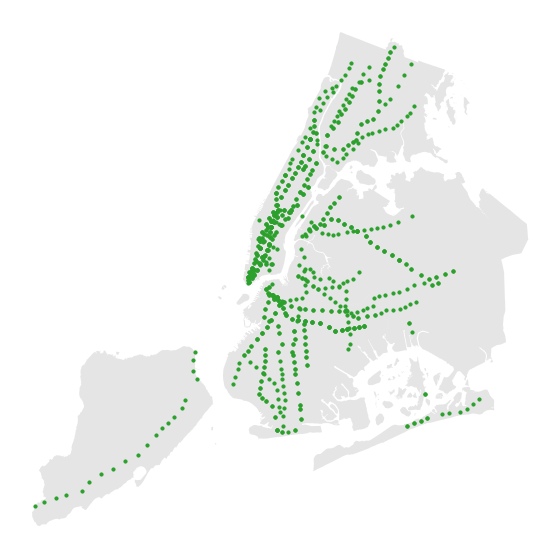

In [ ]:
## only plot sub nodes, and edges between sub nodes
plt.figure(figsize=(10,10))
ax= plt.subplot()
nyc.plot(ax=ax,color= 'grey',alpha=0.2)

## filter out sub nodes
sub = filter(lambda n,attr :attr['master_node']=='No',G.nodes(data=True))

## filter out edges only by transfer and train
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

location = nx.get_node_attributes(G,'geo')
plt.axis("off")
nx.draw_networkx(G,
                 pos = location,
                 #nodelist= G.nodes,
                 edgelist = edges,
                 with_labels =False,
                 node_size = 10,
                 style = 'dotted',
                 node_color= 'C2',
                 edge_color= 'C1')